## The Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from datasets import load_dataset

from torch.nn.functional import cross_entropy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments

## The Dataset

In [4]:
emotions = load_dataset("emotion", trust_remote_code=True) 
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [6]:
print(emotions['train'].column_names) 
print(emotions['train'].features)

['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [11]:
print(emotions['train'][0])

{'text': 'i didnt feel humiliated', 'label': 0}


## The Data

In [14]:
emotions.set_format(type='pandas')
df = emotions['train'][:]
df['label_name'] = df['label'].apply(lambda x: emotions['train'].features['label'].int2str(x))
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


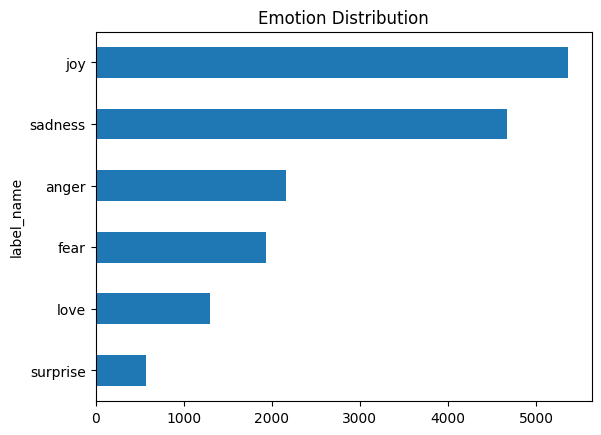

In [15]:
df['label_name'].value_counts(ascending=True).plot(kind='barh')
plt.title('Emotion Distribution')
plt.show()

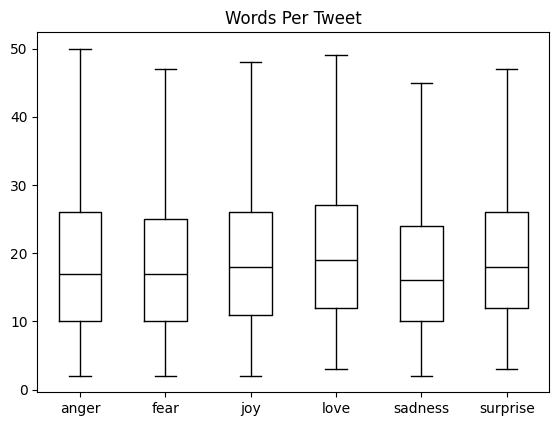

In [16]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot(column='Words Per Tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [17]:
emotions.reset_format()

## The Tokenizer

In [18]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [20]:
emotions_encoded = emotions.map(
    tokenize,
    batched=True,
    batch_size=None,
)


print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## The Hidden States

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [24]:
def extract_hidden_states(batch):

    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_states = model(**inputs).last_hidden_state
    
    return {"hidden_state": last_hidden_states[:,0].cpu().numpy()}


emotions_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)


print(emotions_encoded)
print("==="*10)
print(emotions_hidden)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})


## The Baseline

In [25]:
X_train = emotions_hidden['train']['hidden_state']
X_valid = emotions_hidden['validation']['hidden_state']

y_train = emotions_encoded['train']['label']
y_valid = emotions_encoded['validation']['label']

X_train.shape, y_train.shape

(torch.Size([16000, 768]), torch.Size([16000]))

In [26]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.634

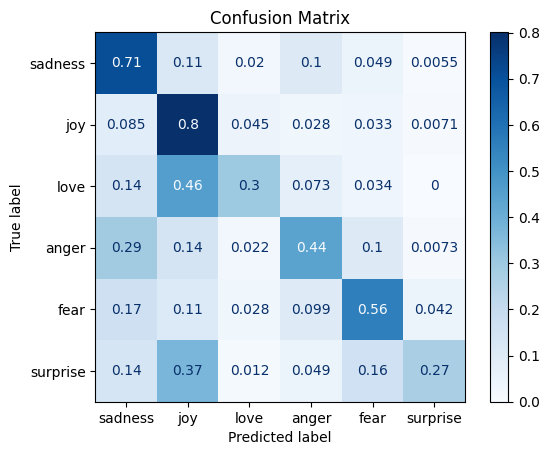

In [27]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

y_pred = lr_clf.predict(X_valid)
plot_confusion_matrix(y_valid, y_pred, labels=emotions['train'].features['label'].names)

## The Fine-tuning

In [29]:
num_labels = len(emotions['train'].features['label'].names)
model_ckpt = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [30]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotions"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

trainer.train()

  0%|          | 0/750 [00:00<?, ?it/s]

{'loss': 0.8091, 'grad_norm': 3.4984800815582275, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2827610373497009, 'eval_accuracy': 0.918, 'eval_f1': 0.9177134657645623, 'eval_runtime': 56.6982, 'eval_samples_per_second': 35.275, 'eval_steps_per_second': 0.564, 'epoch': 1.0}
{'loss': 0.2194, 'grad_norm': 5.975999355316162, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.18332098424434662, 'eval_accuracy': 0.927, 'eval_f1': 0.9275833129918217, 'eval_runtime': 57.0872, 'eval_samples_per_second': 35.034, 'eval_steps_per_second': 0.561, 'epoch': 2.0}
{'loss': 0.1479, 'grad_norm': 4.328969478607178, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.16955548524856567, 'eval_accuracy': 0.931, 'eval_f1': 0.9310191699653281, 'eval_runtime': 57.2896, 'eval_samples_per_second': 34.91, 'eval_steps_per_second': 0.559, 'epoch': 3.0}
{'train_runtime': 5214.5243, 'train_samples_per_second': 9.205, 'train_steps_per_second': 0.144, 'train_loss': 0.3921130065917969, 'epoch': 3.0}


TrainOutput(global_step=750, training_loss=0.3921130065917969, metrics={'train_runtime': 5214.5243, 'train_samples_per_second': 9.205, 'train_steps_per_second': 0.144, 'train_loss': 0.3921130065917969, 'epoch': 3.0})

## The Evaluation

In [31]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

  0%|          | 0/32 [00:00<?, ?it/s]

{'test_loss': 0.16955548524856567,
 'test_accuracy': 0.931,
 'test_f1': 0.9310191699653281,
 'test_runtime': 60.6958,
 'test_samples_per_second': 32.951,
 'test_steps_per_second': 0.527}

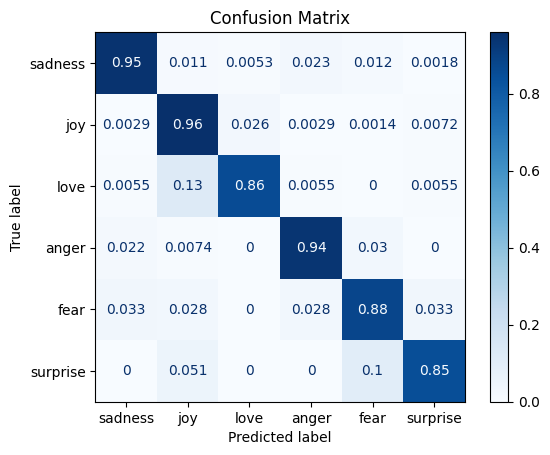

In [32]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels=emotions['validation'].features['label'].names)

In [33]:
def forward_pass_with_label(batch):

    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [34]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label,
    batched=True,
    batch_size=16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [35]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]

df_valid = emotions_encoded["validation"][:][cols]
df_valid['label'] = df_valid['label'].apply(lambda x: emotions['train'].features['label'].int2str(x))
df_valid['predicted_label'] = df_valid['predicted_label'].apply(lambda x: emotions['train'].features['label'].int2str(x))

In [36]:
df_valid.sort_values(by="loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,6.292013
1963,i called myself pro life and voted for perry w...,joy,sadness,6.010416
882,i feel badly about reneging on my commitment t...,love,sadness,5.851896
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.773645
1111,im lazy my characters fall into categories of ...,joy,fear,5.531428
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.464278
1801,i feel that he was being overshadowed by the s...,love,sadness,4.986735
1964,i feel vaguely cheated and a little amused,joy,anger,4.944654
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.451324
1683,i had applied for a job and they had assured m...,anger,joy,4.274085


In [37]:
df_valid.sort_values(by="loss", ascending=True).head(10)

,text,label,predicted_label,loss
69,i have no extra money im worried all of the ti...,sadness,sadness,0.007337
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.007429
620,i shall move right along to the post interview...,joy,joy,0.007456
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.007459
1873,i feel practically virtuous this month i have ...,joy,joy,0.007469
669,i am not feeling very joyful today its been a ...,joy,joy,0.007493
323,im starting to feel unwelcome in there,sadness,sadness,0.007506
1263,i feel this way about blake lively,joy,joy,0.007537
578,i got to christmas feeling positive about the ...,joy,joy,0.007542
382,i feel cool because the plane has four seats i...,joy,joy,0.007561


## The Analysis

In [41]:
preds_output = trainer.predict(emotions_encoded["test"])
preds_output.metrics

  0%|          | 0/32 [00:00<?, ?it/s]

{'test_loss': 0.17953936755657196,
 'test_accuracy': 0.9195,
 'test_f1': 0.919221484466421,
 'test_runtime': 53.9393,
 'test_samples_per_second': 37.079,
 'test_steps_per_second': 0.593}

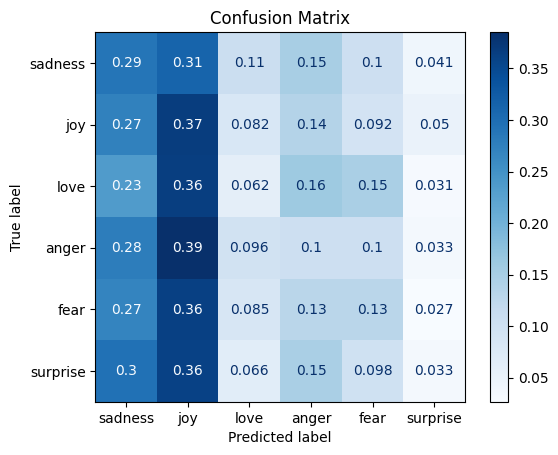

In [42]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels=emotions['test'].features['label'].names)

In [38]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

emotions_encoded["test"] = emotions_encoded["test"].map(
    forward_pass_with_label,
    batched=True,
    batch_size=16
)

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]

df_test = emotions_encoded["test"][:][cols]
df_test['label'] = df_test['label'].apply(lambda x: emotions['train'].features['label'].int2str(x))
df_test['predicted_label'] = df_test['predicted_label'].apply(lambda x: emotions['train'].features['label'].int2str(x))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [39]:
df_test.sort_values(by="loss", ascending=False).head(10)

,text,label,predicted_label,loss
1382,i cannot even begin to express in words the de...,surprise,sadness,6.517347
1253,i don t feel betrayed coz the backstabber had ...,surprise,sadness,6.330812
816,whenever i put myself in others shoes and try ...,anger,joy,6.190598
290,i just feel are ludicrous and wasting space or...,surprise,sadness,6.110229
1613,i feel very cheated since i am supporting the ...,joy,sadness,6.052036
125,i feel very mislead by someone that i really r...,love,anger,5.602691
1270,i feel very saddened that the king whom i once...,joy,sadness,5.581417
1533,i actually was in a meeting last week where so...,anger,sadness,5.347130
1020,i know is that she s here and i m so thankful ...,sadness,joy,5.175680
660,i was playing a sport in an advanced pe class ...,anger,joy,4.641333


In [40]:
df_test.sort_values(by="loss", ascending=True).head(10)

,text,label,predicted_label,loss
116,i feel thoroughly virtuous even if the daily t...,joy,joy,0.007206
1193,i start working full time next week where i m ...,sadness,sadness,0.007251
1175,i don t feel the least bit unwelcome in my par...,sadness,sadness,0.007322
1353,i feel i am appreciative i take care of the ba...,joy,joy,0.007369
198,i receive every month make me proud and feel a...,joy,joy,0.007404
753,i am feeling a bit ungrateful and choose to co...,sadness,sadness,0.007438
944,i feel lonely and sad when i cannot talk to yo...,sadness,sadness,0.007455
1494,i feel like an ungrateful ass a href http this...,sadness,sadness,0.007471
1223,i exactly feel whenever i feel lonely or depre...,sadness,sadness,0.007478
928,i wonder if im vain because i love dressing up...,joy,joy,0.007483
